# **import**

In [70]:
import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # for split
from torchmetrics import Accuracy
from torch.utils.data import TensorDataset, DataLoader

# **Device**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# **load dataset**

In [71]:
data_frame_train = pd.read_csv('/content/train.csv')
date_frame_test = pd.read_csv('/content/test.csv')

# **train**

In [72]:
x_train = data_frame_train.drop('price_range', axis=1)
y_train = data_frame_train['price_range']

split
یک بخشی از داده های جدا می شوند برای ولیدیشن
تا مدل  بهتر
train
بشه

In [73]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, train_size=0.7, random_state=42)

In [ ]:
x_train.head()

# **preprocess**

In [75]:
x_train = torch.FloatTensor(x_train.values) # چون نام پای اَری هست باید مقداریش رو برداریم
y_train = torch.LongTensor(y_train.values) # بخاطر اینکه در دسته بندی هستیم باید از اینتیجر استفاده کنیم


# **validation**

In [76]:
x_valid = torch.FloatTensor(x_valid.values)
y_valid = torch.LongTensor(y_valid.values)

# **Standardization**

In [77]:
mu = x_train.mean(dim=0)
std = x_train.std(dim=0)

In [78]:
x_train = (x_train - mu) / std
x_valid = (x_valid - mu) / std

# *Dataloader*

# **train and validtaion**

In [79]:
train_data = TensorDataset(x_train, y_train)
valid_data = TensorDataset(x_valid, y_valid)

In [80]:
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=200, shuffle=True)

# **Utils**

In [81]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [82]:
loss_meter = AverageMeter()

# ***`Model`***

In [83]:
num_feats = 20
num_class = 4
hiden_layer_one = 64
hiden_layer_two = 32

model = nn.Sequential(nn.Linear(num_feats, hiden_layer_one), # fully connected layer
                      nn.ReLU(), # activation function
                      nn.Linear(hiden_layer_one, hiden_layer_two),
                      nn.ReLU(),
                      nn.Linear(hiden_layer_two, num_class) # classifier layer
                      )

In [ ]:
model = model.to(device)


# **Loss and Optimizer**

In [84]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# **train loop**

In [ ]:
from os import listxattr
num_epochs = 400

loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []


for epoch in range(num_epochs):
    loss_train = AverageMeter()
    acc_train = Accuracy(task='multiclass', num_classes=4).to(device)
    for i, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # train_loss.append(loss)

        loss_train.update(loss.item())
        acc_train(outputs, targets)




    with torch.no_grad():
        loss_valid = AverageMeter()
        acc_valid = Accuracy(task='multiclass', num_classes=4).to(device)

        for i, (inputs, targets) in enumerate(valid_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            # valid_loss.append(loss)
            loss_valid.update(loss.item())

            acc_valid(outputs, targets)

    loss_train_hist.append(loss_train.avg)
    loss_valid_hist.append(loss_valid.avg)

    acc_train_hist.append(acc_train.compute())
    acc_valid_hist.append(acc_valid.compute())




    if epoch % 10 == 0:

        print(f'Epoch {epoch}')

        print(f'Train: Loss = {loss_train.avg:.4}, Acc = {acc_train.compute():.4}')

        print(f'Valid: Loss = {loss_valid.avg:.4}, Acc = {acc_valid.compute():.4}', "\n")



# **plot loss**

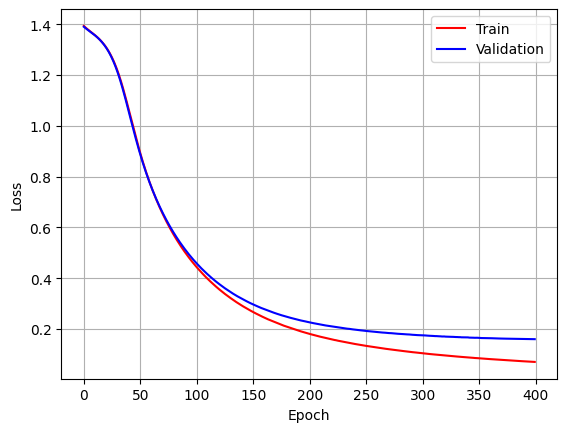

In [87]:
plt.plot(range(num_epochs), loss_train_hist, 'r-', label='Train')
plt.plot(range(num_epochs), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# **plot accuracy**

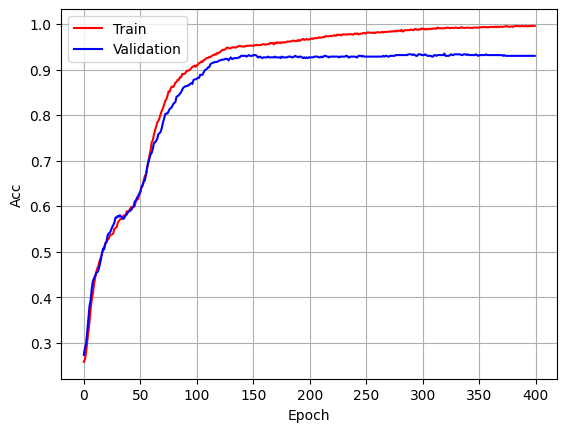

In [86]:
plt.plot(range(num_epochs), acc_train_hist, 'r-', label='Train')
plt.plot(range(num_epochs), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()

# **Save model**


In [ ]:
torch.save(model, 'model.pth')

# **Load model**

In [ ]:
mymodel = torch.load('model.pth')